/tmp/ipykernel_2645/3452782004.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  num_tot_cells = adata.obs.groupby(['short_title']).count()
/tmp/ipykernel_2645/3452782004.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_counts = adata.obs.groupby(['short_title', 'grupos_edades', 'cell_type']).count()


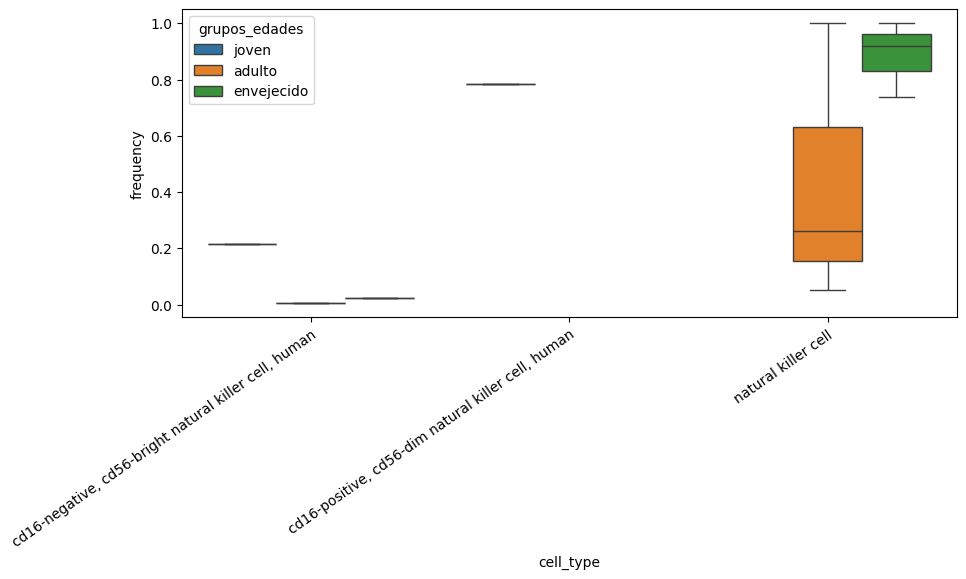

In [1]:
#conteo celular
import scanpy as sc
adata = sc.read_h5ad('/app/project/pipeline_colombia/4.models/scanvi_model/scanvi_integrated.h5ad')
num_tot_cells = adata.obs.groupby(['short_title']).count()
num_tot_cells = dict(zip(num_tot_cells.index, num_tot_cells.assay))
cell_type_counts = adata.obs.groupby(['short_title', 'grupos_edades', 'cell_type']).count()
cell_type_counts = cell_type_counts[cell_type_counts.sum(axis = 1) > 0].reset_index()
cell_type_counts = cell_type_counts[cell_type_counts.columns[0:4]]
cell_type_counts['total_cells'] = cell_type_counts.short_title.map(num_tot_cells).astype(int)
cell_type_counts['frequency'] = cell_type_counts.donor_id / cell_type_counts.total_cells


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (10,4))

ax = sns.boxplot(data = cell_type_counts, x = 'cell_type', y = 'frequency', hue = 'grupos_edades')

plt.xticks(rotation = 35, rotation_mode = 'anchor', ha = 'right')

plt.show()


Expresión Diferencial con SCVI

In [2]:
#subset = adata.copy()
#subset = adata[adata.obs['cell_type'].isin([ "CD16-negative, CD56-bright natural killer cell, human"])].copy()
#subset= adata.raw.to_adata().copy()
#subset = adata[adata.obs['grupos_edades'].isin([ "joven", 'envejecido'])]
#subset

In [82]:
adata.obs['donor_id'].unique()

['H1', 'H2', 'H3', 'H4', 'H5', ..., 'Normal 1', 'Normal 4', 'Normal 3', 'Normal 2', '1']
Length: 17
Categories (17, object): ['1', 'CONTROL', 'H1', 'H2', ..., 'cov08', 'cov09', 'cov17', 'cov18']

In [84]:
adata.obs['grupos_edades'].value_counts()

grupos_edades
envejecido    6433
adulto        4623
joven         1150
Name: count, dtype: int64

In [92]:
adata_jovenes = adata[adata.obs['grupos_edades'] == 'jovenes'].copy()
adata_jovenes

AnnData object with n_obs × n_vars = 0 × 2000
    obs: 'donor_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_group', 'años', 'grupos_edades', 'source_file', 'title', 'short_title', 'n_genes_by_counts', 'total_counts', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'complexity', '_scvi_batch', '_scvi_labels', 'doublet_score', 'singlet_score', 'doublet_prediction', 'leiden', 'scanvi_leiden', '_scvi_raw_norm_scaling', 'datp'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'genome', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'modality', 'neighbors', 'pca', 'scanvi_leiden', 'scanvi_leiden_colors', 'short_title

In [94]:
adata_jovenes.obs['donor_id'].unique()

[], Categories (0, object): []

/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO     File /app/project/pipeline_colombia/4.models/scanvi_model/model.pt already downloaded                     


/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/scvi/model/base/_utils.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_locati

DE...: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


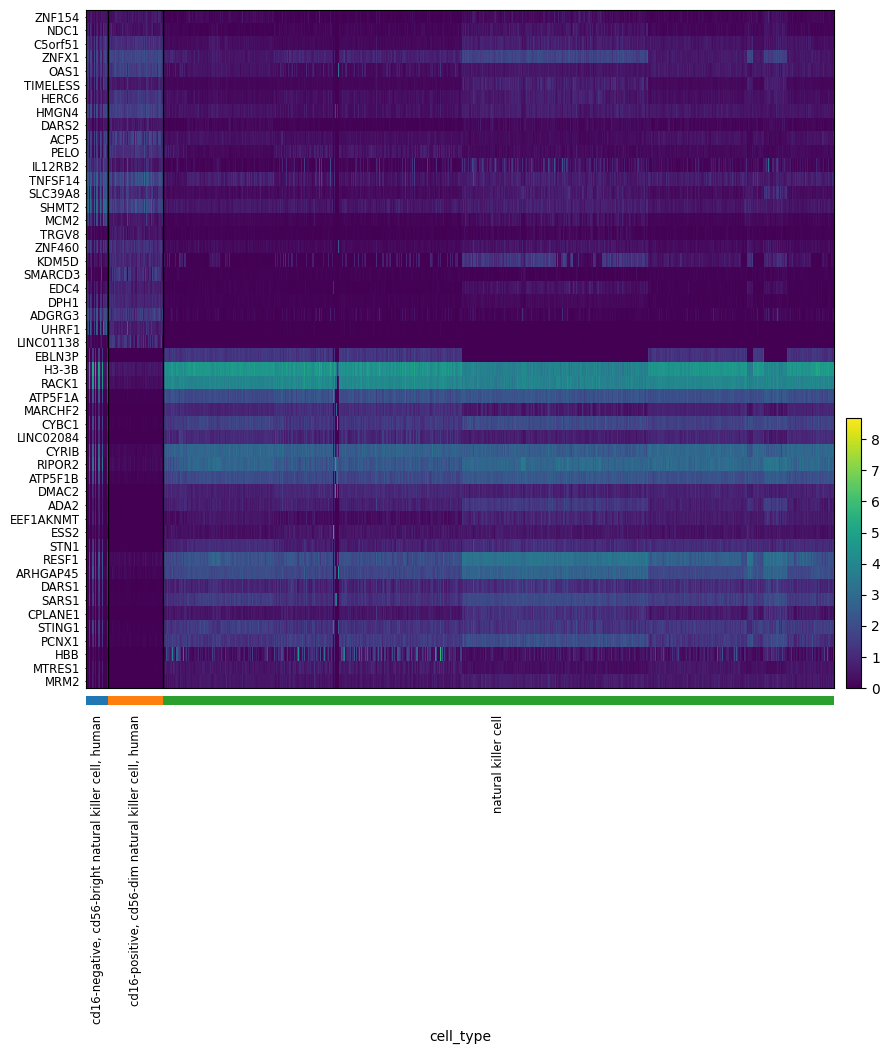

In [3]:
import scvi
model  = scvi.model.SCANVI.load('/app/project/pipeline_colombia/4.models/scanvi_model/', adata)
adata.layers['scanvi_normalized'] = model.get_normalized_expression(library_size = 1e4)

scvi_de = model.differential_expression(
    idx1 = [adata.obs['grupos_edades'] == 'joven'],
    idx2 = [adata.obs['grupos_edades'] == 'envejecido'])

#any set of cells vs any set of cells
# scvi_de = model.differential_expression(
#     idx1 = [(adata.obs['cell type'].isin(['AT1', 'AT2'])) & (adata.obs.condition == 'COVID19')],
#     idx2 = [(adata.obs['cell type'].isin(['AT1', 'AT2'])) & (adata.obs.condition == 'control')]
#     )

scvi_de = scvi_de[(scvi_de['is_de_fdr_0.05']) & (abs(scvi_de.lfc_mean) > .5)]
scvi_de = scvi_de.sort_values('lfc_mean')
scvi_de = scvi_de[(scvi_de.raw_normalized_mean1 > .5) | (scvi_de.raw_normalized_mean2 > .5)]
genes_to_show = scvi_de[-25:].index.tolist() + scvi_de[:25].index.tolist() #top 25 and bottom 25 from sorted df

sc.pl.heatmap(adata, genes_to_show, groupby='cell_type', swap_axes=True, layer = 'scanvi_normalized',
              log = True)



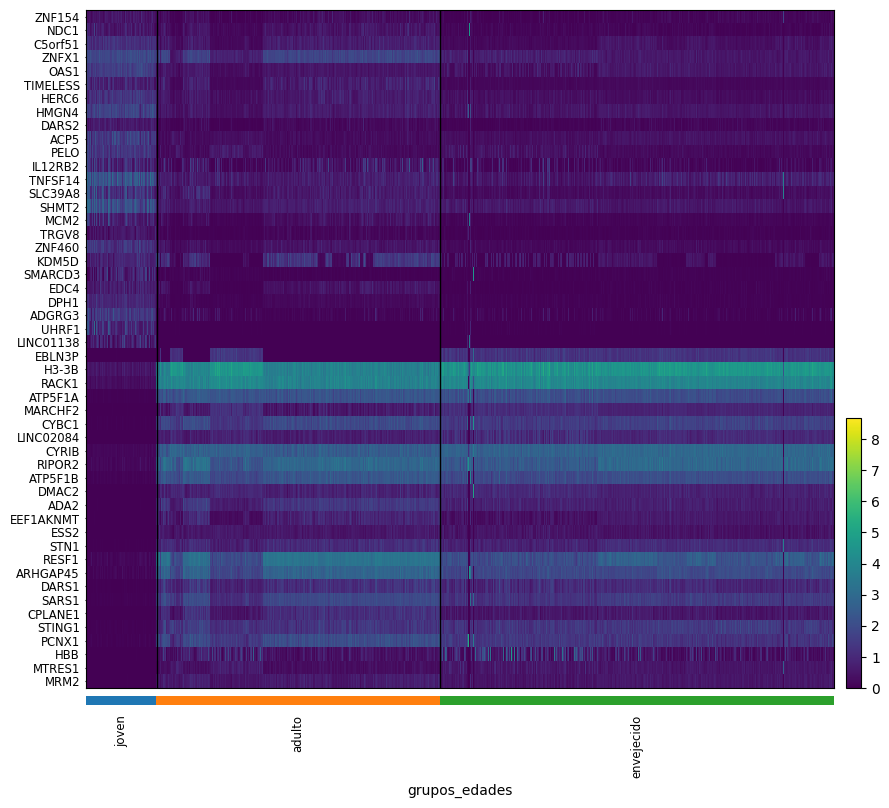

In [4]:
sc.pl.heatmap(adata, genes_to_show, groupby='grupos_edades', swap_axes=True, layer = 'scanvi_normalized',
              log = True)


/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Volcano Plot')

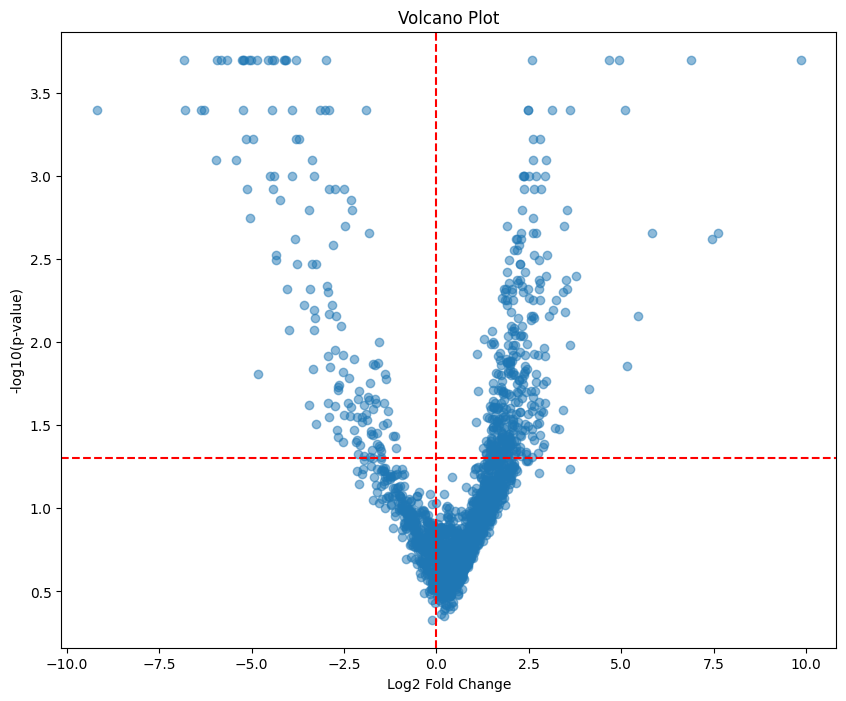

In [67]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,8))
plt.scatter(
    scvi_de.lfc_mean,
    -np.log10(scvi_de.proba_not_de),
    alpha=0.5
)
plt.axhline(y=-np.log10(0.05), color='r', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot')

GO Enrrichment

In [5]:
import gseapy as gp

In [6]:
gp.get_library_name()
#'GO_Biological_Process_2023', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up',  'WikiPathways_2024_Human
# 'GTEx_Aging_Signatures_2021', 'KEGG_2021_Human', 'RNAseq_Automatic_GEO_Signatures_Human_Down', 'RNAseq_Automatic_GEO_Signatures_Human_Up',


['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DGIdb_Drug_Targets_2024',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_CRISPR_GeneDependency_CellLines_2023',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_Cell

In [7]:
scvi_de = model.differential_expression(
    idx1 = [adata.obs['grupos_edades'] == 'joven'],
    idx2 = [adata.obs['grupos_edades'] == 'envejecido'])
scvi_de

DE...: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05
featurekey,,,,,,,,,,,,,,,,,,,
BRD3OS,1.0000,0.0000,18.420681,2.951899e-07,2.089437e-05,0.0,0.25,-5.777804,-6.077846,3.442463,-13.821046,48.604897,0.000000,0.229908,0.000000,0.017721,0.000000,0.195457,True
SARS1,1.0000,0.0000,18.420681,5.991172e-06,3.184984e-04,0.0,0.25,-5.575388,-5.746712,2.132736,-9.670276,34.856640,0.000000,1.568320,0.000000,0.254003,0.000000,3.142147,True
WARS1,1.0000,0.0000,18.420681,2.272493e-06,8.760235e-05,0.0,0.25,-5.106822,-5.340652,2.478515,-10.529418,35.597145,0.000000,0.495881,0.000000,0.068397,0.000000,0.727990,True
FBH1,1.0000,0.0000,18.420681,2.591216e-06,8.547023e-05,0.0,0.25,-4.859420,-5.166055,3.085337,-10.996502,36.949715,0.000000,0.597855,0.000000,0.073993,0.000000,0.800403,True
CCL20,1.0000,0.0000,18.420681,4.239567e-05,5.832604e-08,0.0,0.25,9.632193,9.037750,4.866707,1.525843,76.377319,0.040000,0.000000,0.010435,0.000000,0.470254,0.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PEX2,0.5952,0.4048,0.385504,2.810762e-04,2.662357e-04,0.0,0.25,0.369651,0.113460,2.430017,-5.171331,34.348106,0.086087,0.709778,0.084348,0.204881,2.739100,2.388124,False
AQR,0.5930,0.4070,0.376381,1.774681e-04,1.867349e-04,0.0,0.25,0.209108,-0.038355,2.559305,-5.750958,37.256832,0.044348,0.591015,0.043478,0.127468,1.628332,1.449519,False
MRPS30,0.5660,0.4340,0.265550,2.553822e-04,2.807942e-04,0.0,0.25,0.133852,-0.067477,2.279900,-6.465995,33.058800,0.093043,0.636872,0.083478,0.198352,2.839040,2.282752,False


In [45]:
genes_up_envejecidos = scvi_de[
    (scvi_de['is_de_fdr_0.05']) & 
    (scvi_de.lfc_median > 0)
].index.tolist()



In [48]:

genes_up_jovenes  = scvi_de[
    (scvi_de['is_de_fdr_0.05']) & 
    (scvi_de.lfc_median < 0)
].index.tolist()


In [49]:
enr = gp.enrichr(gene_list= genes_up_jovenes,
                 gene_sets=['GO_Biological_Process_2023', 
                            'KEGG_2021_Human'],
                 organism='human', # don't forget to set organism to the one you desired!
                 outdir=None, # don't write to disk,
                 background = adata.var_names.tolist()
                )

In [50]:
enr.results

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2023,Phospholipase C-activating G Protein-Coupled R...,0.000389,0.526735,0,0,15.559006,122.155892,GPR174;CX3CR1;CXCR2;NMUR1;F2RL2;CMKLR1
1,GO_Biological_Process_2023,Positive Regulation Of Protein Modification Pr...,0.002097,0.538394,0,0,6.055036,37.343075,LYN;FBH1;PRKCD;RACK1;NSMF;CALM1;RAMP1
2,GO_Biological_Process_2023,Regulation Of Establishment Of Cell Polarity (...,0.003099,0.538394,0,0,20.629630,119.168946,RIPOR2;GSN;RACK1;CYRIB
3,GO_Biological_Process_2023,Regulation Of Establishment Or Maintenance Of ...,0.003099,0.538394,0,0,20.629630,119.168946,RIPOR2;RACK1;CYRIB;LLGL2
4,GO_Biological_Process_2023,Regulation Of Neuron Differentiation (GO:0045664),0.003099,0.538394,0,0,20.629630,119.168946,ID2;NREP;CDK5R1;FGFR1
...,...,...,...,...,...,...,...,...,...
1515,KEGG_2021_Human,Protein processing in endoplasmic reticulum,0.980461,0.999593,0,0,0.324758,0.006408,AMFR;BAG1
1516,KEGG_2021_Human,Epstein-Barr virus infection,0.990806,0.999593,0,0,0.201468,0.001861,LYN
1517,KEGG_2021_Human,Hepatitis B,0.990806,0.999593,0,0,0.201468,0.001861,MAP3K1
1518,KEGG_2021_Human,Pathogenic Escherichia coli infection,0.993608,0.999593,0,0,0.186318,0.001195,MYH10


Comparación

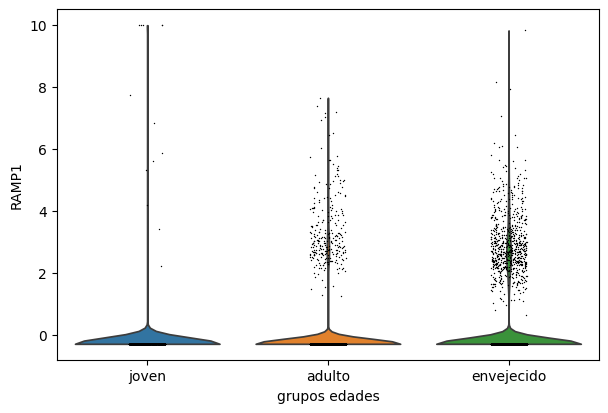

In [57]:
sc.pl.violin(adata, 'RAMP1', groupby='grupos_edades')

In [68]:
#Análisis no paramétrico para determinar diferencias entre grupos por gen
from scipy import stats
import numpy as np
#temp = subset[subset.obs.cell_type == 'AT2']

i = np.where(adata.var_names == 'RAMP1')[0][0]

a = adata[adata.obs.grupos_edades == 'joven'].X[:,i]
b = adata[adata.obs.grupos_edades == 'envejecido'].X[:,i]
stats.mannwhitneyu(a, b)

MannwhitneyuResult(statistic=3334018.5, pvalue=1.482755041320964e-25)

Score gene signature

In [62]:
#gene signature, ie, input list of genes from user
with open('/app/project/pipeline_colombia/5.0analysis/gtx_aging_singatures_blood_up.txt') as f:
    datp_sig = [x.strip() for x in list(f)]

In [63]:
sc.tl.score_genes(adata, datp_sig, score_name = 'datp')

       'H2BC8', 'GLYAT',
       ...
       'LBP', 'KNG1', 'H2BC19P', 'CXCL8', 'CFHR2', 'H1-4', 'TGFBR3', 'OR52E3P',
       'APOB', 'DNAJB1'],
      dtype='object', length=239)


In [64]:
adata.obs

,donor_id,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,cell_group,...,complexity,_scvi_batch,_scvi_labels,doublet_score,singlet_score,doublet_prediction,leiden,scanvi_leiden,_scvi_raw_norm_scaling,datp
barcodekey,,,,,,,,,,,,,,,,,,,,,
HIP002.114,H1,natural killer cell,seq-well,normal,homo sapiens,female,blood,european,49-year-old human stage,nk cells,...,0.475189,3,2,0.384735,0.615265,singlet,0,1,22.988506,-0.354230
HIP002.183,H1,natural killer cell,seq-well,normal,homo sapiens,female,blood,european,49-year-old human stage,nk cells,...,0.522349,3,2,0.001257,0.998743,singlet,11,6,34.364261,-0.058152
HIP002.203,H1,natural killer cell,seq-well,normal,homo sapiens,female,blood,european,49-year-old human stage,nk cells,...,0.497854,3,2,0.003447,0.996553,singlet,11,6,28.571429,-0.451267
HIP002.207,H1,natural killer cell,seq-well,normal,homo sapiens,female,blood,european,49-year-old human stage,nk cells,...,0.531556,3,2,0.000593,0.999408,singlet,7,3,32.154341,-0.417988
HIP002.246,H1,natural killer cell,seq-well,normal,homo sapiens,female,blood,european,49-year-old human stage,nk cells,...,0.531469,3,2,0.000101,0.999899,singlet,2,1,33.670034,0.303941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N2_BP1_wbc.gencode.vH29,1,natural killer cell,smart-seq2,normal,homo sapiens,male,blood,unknown,75-year-old human stage,nk cells,...,0.012567,4,2,0.999832,0.000168,doublet,4,2,0.153445,-0.230675
O14_BP5_wbc.gencode.vH29,1,natural killer cell,smart-seq2,normal,homo sapiens,male,blood,unknown,75-year-old human stage,nk cells,...,0.003896,4,2,0.144225,0.855775,singlet,12,1,0.039301,0.637924
O2_BP12_wbc.gencode.vH29,1,natural killer cell,smart-seq2,normal,homo sapiens,male,blood,unknown,75-year-old human stage,nk cells,...,0.006301,4,2,0.978834,0.021166,doublet,4,2,0.067008,0.169734


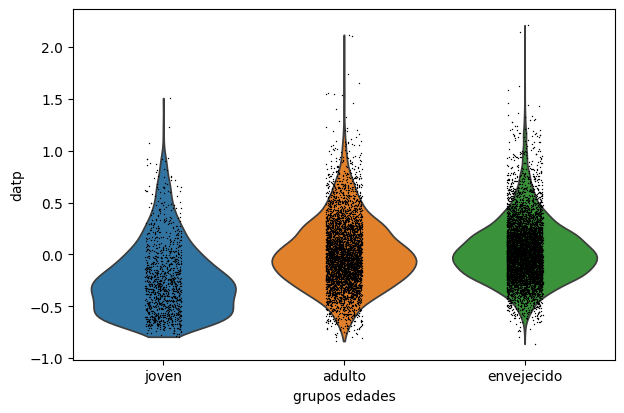

In [65]:
sc.pl.violin(adata, 'datp', groupby='grupos_edades')

In [66]:
a = adata[adata.obs.grupos_edades == 'joven'].obs.datp.values
b = adata[adata.obs.grupos_edades == 'envejecido'].obs.datp.values
stats.mannwhitneyu(a, b)

MannwhitneyuResult(statistic=1863218.0, pvalue=9.066260797604615e-159)

Fuera del flujo test 


In [70]:
# Identificar genes con cambios más dramáticos
top_cambios = scvi_de[scvi_de['is_de_fdr_0.05']].sort_values('lfc_mean', ascending=False)

# Genes sobreexpresados en envejecidos
genes_up = scvi_de[
    (scvi_de['is_de_fdr_0.05']) & 
    (scvi_de.lfc_mean > 1)  # más del doble de expresión
].index.tolist()

# Genes subexpresados en envejecidos
genes_down = scvi_de[
    (scvi_de['is_de_fdr_0.05']) & 
    (scvi_de.lfc_mean < -1)  # menos de la mitad de expresión
].index.tolist()

In [71]:
# Usando gseapy (gprofiler)
import gseapy as gp

# Enriquecimiento para genes sobreexpresados
enr_up = gp.enrichr(
    gene_list=genes_up,
    gene_sets=['GO_Biological_Process_2021', 'KEGG_2021_Human'],
    organism='human'
)

# Enriquecimiento para genes subexpresados
enr_down = gp.enrichr(
    gene_list=genes_down,
    gene_sets=['GO_Biological_Process_2021', 'KEGG_2021_Human'],
    organism='human'
)

In [72]:
# Usando herramientas como KEGG o Reactome
# Ejemplo con KEGG
kegg_enrich = gp.enrichr(
    gene_list=genes_up + genes_down,
    gene_sets=['KEGG_2021_Human'],
    organism='human'
)

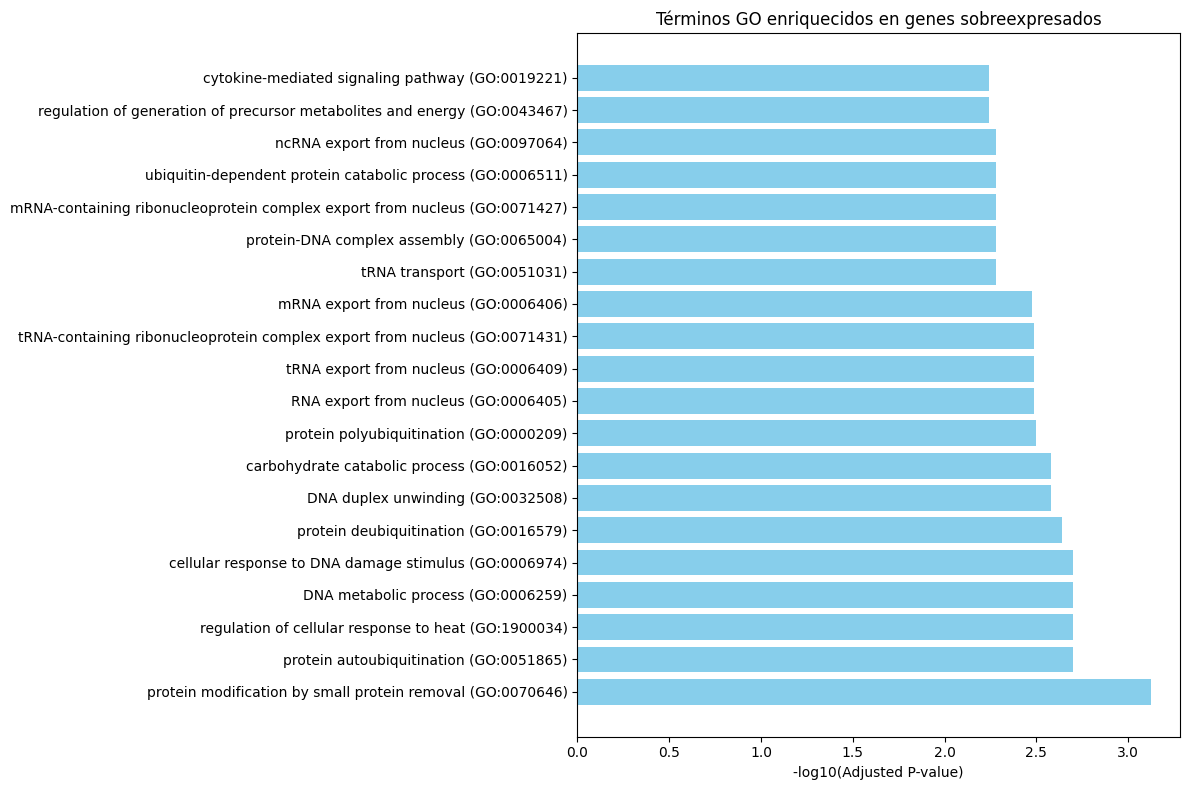

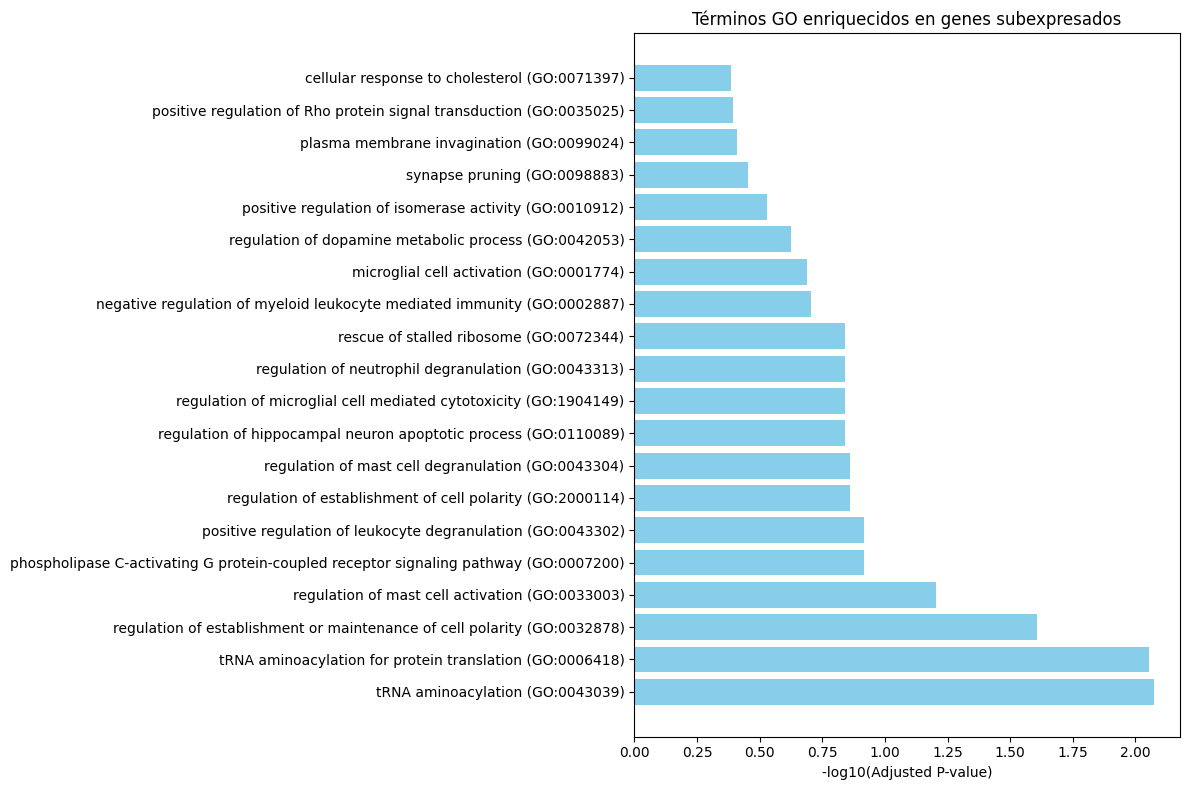

In [73]:
# Visualización básica de términos enriquecidos
def plot_enrichment(enr_result, title, top_terms=20):
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Obtener los top términos
    res_df = enr_result.results
    res_df = res_df.head(top_terms)
    
    plt.figure(figsize=(12, 8))
    plt.barh(
        y=np.arange(len(res_df)),
        width=-np.log10(res_df['Adjusted P-value']),
        color='skyblue'
    )
    plt.yticks(np.arange(len(res_df)), res_df['Term'])
    plt.xlabel('-log10(Adjusted P-value)')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Para genes sobreexpresados
plot_enrichment(enr_up, 'Términos GO enriquecidos en genes sobreexpresados')

# Para genes subexpresados
plot_enrichment(enr_down, 'Términos GO enriquecidos en genes subexpresados')

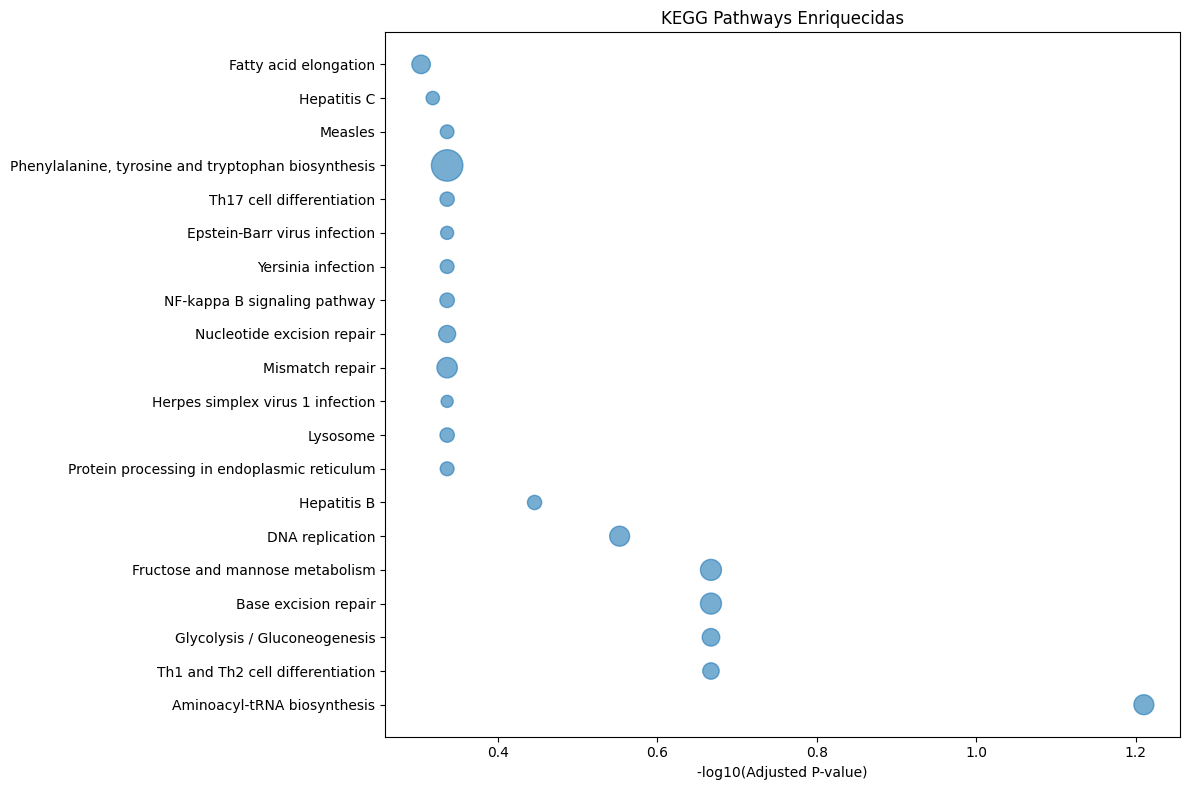

In [74]:
def plot_enrichment_dotplot(enr_result, title, top_terms=20):
    import matplotlib.pyplot as plt
    
    res_df = enr_result.results.head(top_terms)
    
    plt.figure(figsize=(12, 8))
    plt.scatter(
        x=-np.log10(res_df['Adjusted P-value']),
        y=range(len(res_df)),
        s=res_df['Odds Ratio'] * 50,  # Tamaño proporcional al Odds Ratio
        alpha=0.6
    )
    plt.yticks(range(len(res_df)), res_df['Term'])
    plt.xlabel('-log10(Adjusted P-value)')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_enrichment_dotplot(kegg_enrich, 'KEGG Pathways Enriquecidas')

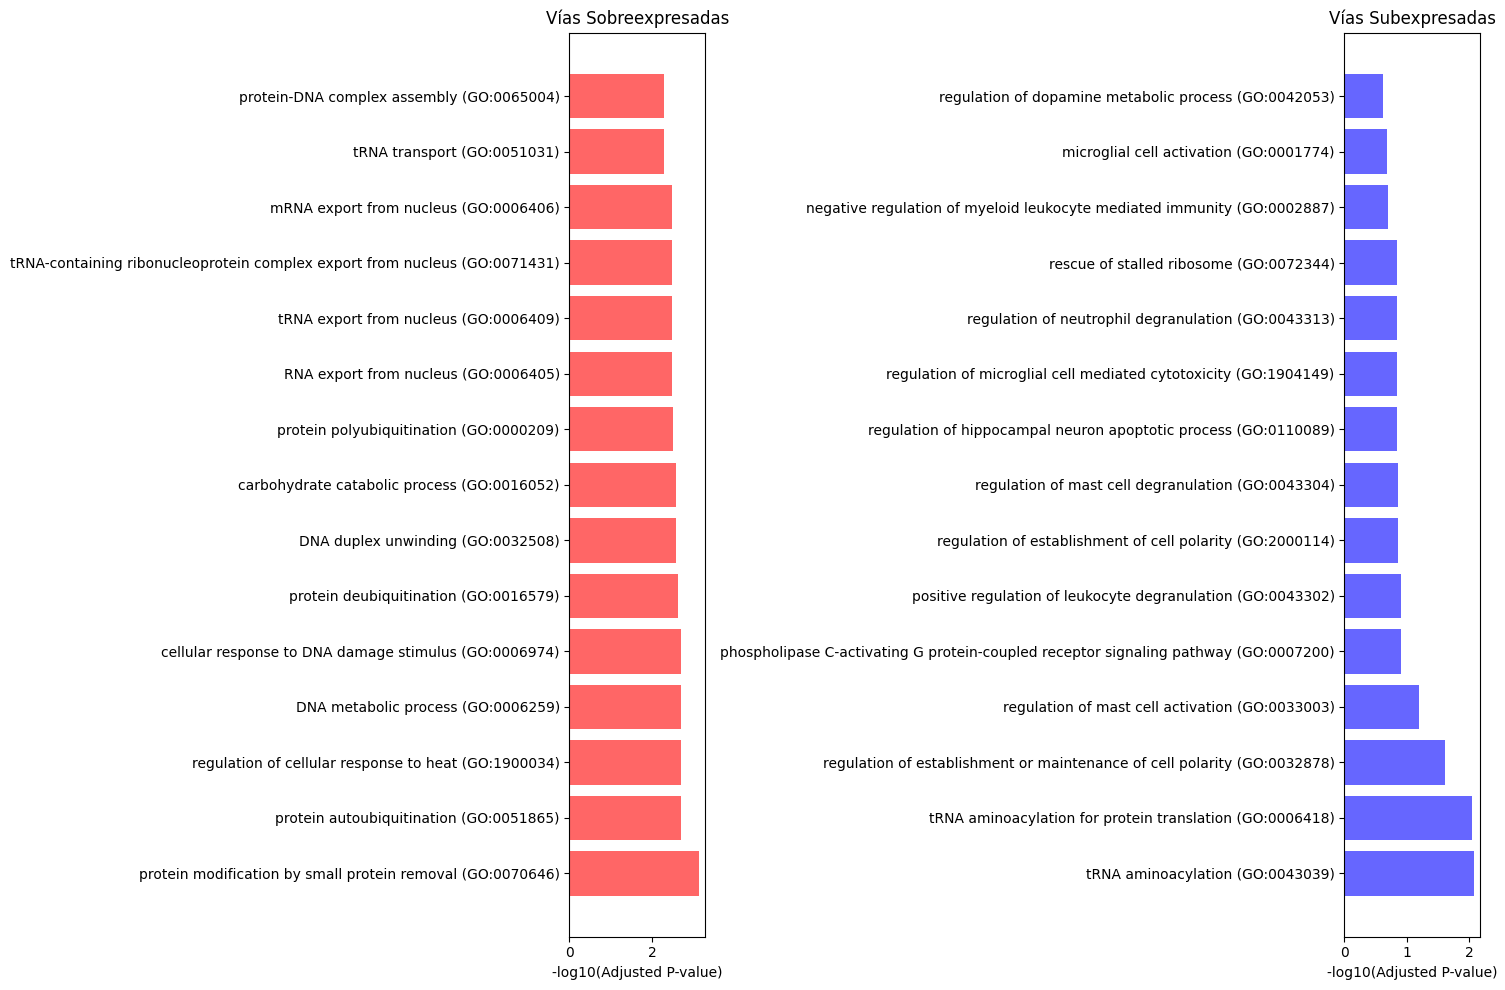

In [75]:
def compare_pathways(enr_up, enr_down, top_terms=15):
    # Preparar datos
    up_df = enr_up.results.head(top_terms)
    down_df = enr_down.results.head(top_terms)
    
    plt.figure(figsize=(15, 10))
    
    # Plot para up-regulated
    plt.subplot(121)
    plt.barh(
        range(len(up_df)),
        -np.log10(up_df['Adjusted P-value']),
        color='red',
        alpha=0.6
    )
    plt.yticks(range(len(up_df)), up_df['Term'])
    plt.xlabel('-log10(Adjusted P-value)')
    plt.title('Vías Sobreexpresadas')
    
    # Plot para down-regulated
    plt.subplot(122)
    plt.barh(
        range(len(down_df)),
        -np.log10(down_df['Adjusted P-value']),
        color='blue',
        alpha=0.6
    )
    plt.yticks(range(len(down_df)), down_df['Term'])
    plt.xlabel('-log10(Adjusted P-value)')
    plt.title('Vías Subexpresadas')
    
    plt.tight_layout()
    plt.show()

compare_pathways(enr_up, enr_down)

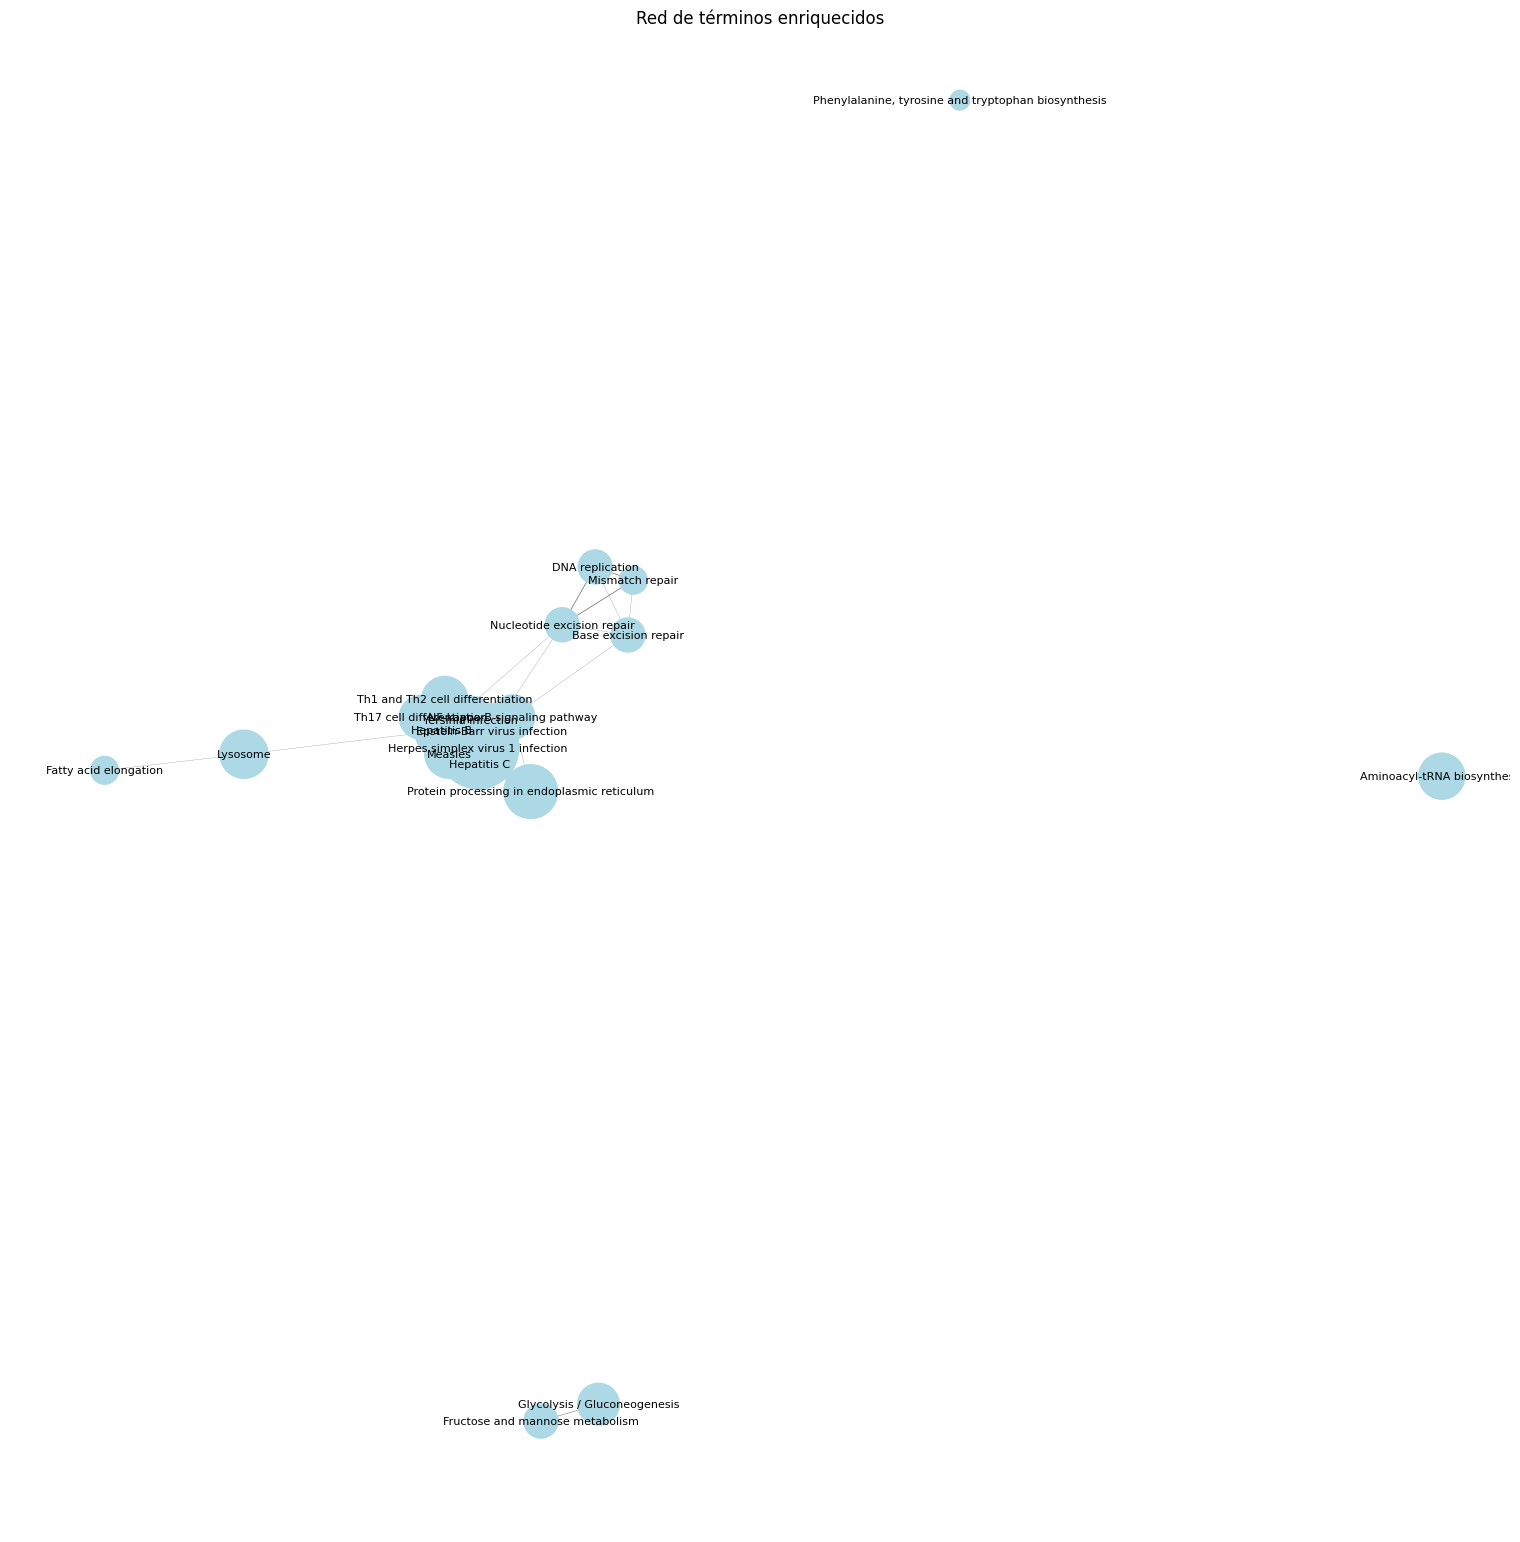

In [76]:
def plot_enrichment_network(enr_result, top_terms=20):
    import networkx as nx
    
    # Crear grafo
    G = nx.Graph()
    
    # Obtener top términos
    terms = enr_result.results.head(top_terms)
    
    # Añadir nodos y edges basados en genes compartidos
    for idx, row in terms.iterrows():
        term = row['Term']
        genes = set(row['Genes'].split(';'))
        G.add_node(term, size=len(genes))
        
        # Conectar con otros términos si comparten genes
        for idx2, row2 in terms.iterrows():
            if idx2 <= idx:
                continue
            genes2 = set(row2['Genes'].split(';'))
            shared = len(genes.intersection(genes2))
            if shared > 0:
                G.add_edge(term, row2['Term'], weight=shared)
    
    # Visualizar
    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(G)
    nx.draw(
        G, pos,
        node_size=[G.nodes[node]['size']*100 for node in G.nodes],
        node_color='lightblue',
        with_labels=True,
        font_size=8,
        edge_color='gray',
        width=[G[u][v]['weight']/5 for u,v in G.edges()]
    )
    plt.title('Red de términos enriquecidos')
    plt.show()

plot_enrichment_network(kegg_enrich)

In [77]:
def format_enrichment_results(enr_result, top_terms=20):
    results = enr_result.results.head(top_terms)
    
    # Formatear para mejor visualización
    formatted_results = results[[
        'Term', 
        'Adjusted P-value', 
        'Odds Ratio',
        'Combined Score',
        'Genes'
    ]].copy()
    
    # Redondear valores numéricos
    formatted_results['Adjusted P-value'] = formatted_results['Adjusted P-value'].apply(lambda x: f"{x:.2e}")
    formatted_results['Odds Ratio'] = formatted_results['Odds Ratio'].round(2)
    formatted_results['Combined Score'] = formatted_results['Combined Score'].round(2)
    
    # Contar genes por término
    formatted_results['Gene Count'] = formatted_results['Genes'].str.count(';') + 1
    
    return formatted_results

# Mostrar resultados formateados
kegg_results = format_enrichment_results(kegg_enrich)
print("KEGG Pathways Enriquecidas:")
print(kegg_results)

KEGG Pathways Enriquecidas:
                                                 Term Adjusted P-value  \
0                         Aminoacyl-tRNA biosynthesis         6.16e-02   
1                    Th1 and Th2 cell differentiation         2.15e-01   
2                        Glycolysis / Gluconeogenesis         2.15e-01   
3                                Base excision repair         2.15e-01   
4                     Fructose and mannose metabolism         2.15e-01   
5                                     DNA replication         2.80e-01   
6                                         Hepatitis B         3.58e-01   
7         Protein processing in endoplasmic reticulum         4.61e-01   
8                                            Lysosome         4.61e-01   
9                    Herpes simplex virus 1 infection         4.61e-01   
10                                    Mismatch repair         4.61e-01   
11                         Nucleotide excision repair         4.61e-01   
12        

In [78]:
def plot_pathway_gene_heatmap(enr_result, expression_data, top_terms=10):
    # Obtener top términos y sus genes
    terms = enr_result.results.head(top_terms)
    
    # Crear matriz de genes por vía
    pathway_gene_matrix = np.zeros((len(terms), len(expression_data)))
    
    for i, (_, row) in enumerate(terms.iterrows()):
        genes = row['Genes'].split(';')
        for j, gene in enumerate(expression_data.index):
            if gene in genes:
                pathway_gene_matrix[i, j] = 1
    
    # Plotear heatmap
    plt.figure(figsize=(15, 8))
    sns.heatmap(
        pathway_gene_matrix,
        yticklabels=terms['Term'],
        xticklabels=expression_data.index,
        cmap='YlOrRd'
    )
    plt.title('Genes por Vía Enriquecida')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()